In [53]:
import torch
from torch import nn
from matplotlib import pyplot as plt 
import numpy as np
from sklearn.model_selection import train_test_split


LSTM preprocessing

In [54]:
# Load preprocessed data
theta = np.load(r"C:\Users\xskap\Documents\Eindhoven\2025_Q4\5SC28_ML_systems_control\lstm\theta.npy")  # shape: (T,)
omega = np.load(r"C:\Users\xskap\Documents\Eindhoven\2025_Q4\5SC28_ML_systems_control\lstm\omega.npy")  # shape: (T,)
u = np.load(r"C:\Users\xskap\Documents\Eindhoven\2025_Q4\5SC28_ML_systems_control\lstm\u.npy")          # shape: (T,)

# Normalize
theta_mean, theta_std = theta.mean(), theta.std()
omega_mean, omega_std = omega.mean(), omega.std()
u_mean, u_std = u.mean(), u.std()

theta = (theta - theta_mean) / theta_std
omega = (omega - omega_mean) / omega_std
u = (u - u_mean) / u_std

Model

In [55]:
# NOELSTM Model
class NOELSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional=False, dropout=0.0):
        super(NOELSTM, self).__init__()
        self.bidirectional = bidirectional
        direction_factor = 2 if bidirectional else 1

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, 
                            bidirectional=bidirectional,
                            dropout=dropout if num_layers > 1 else 0.0).double()

        self.fc = nn.Linear(hidden_size * direction_factor, output_size).double()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [56]:
# Define parameters for the model

# I want hs64_lr0.01_nl1_bs128_sl15_ep200_bi0_do0.2

hidden_size = 64
num_layers = 1
sequence_length = 15
bidirectional = False 
dropout = 0.2


Create Sequence

In [57]:
# Create Sequences for NOE
def create_sequences(theta, omega, u, seq_len):
    X, Y = [], []
    for i in range(len(theta) - seq_len):
        x_seq = np.stack([theta[i:i+seq_len], omega[i:i+seq_len], u[i:i+seq_len]], axis=1)
        y_target = [theta[i+seq_len], omega[i+seq_len]]
        X.append(x_seq)
        Y.append(y_target)
    return np.array(X), np.array(Y)

X, Y = create_sequences(theta, omega, u, sequence_length)

# Convert to tensors
X_tensor = torch.tensor(X).double()
Y_tensor = torch.tensor(Y).double()

# Split: 80% train, 10% val, 10% test
total = len(X_tensor)
train_end = int(0.8 * total)
val_end = int(0.9 * total)

X_train, Y_train = X_tensor[:train_end], Y_tensor[:train_end]
X_val, Y_val = X_tensor[train_end:val_end], Y_tensor[train_end:val_end]
X_test, Y_test = X_tensor[val_end:], Y_tensor[val_end:]

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
   

In [58]:
model = NOELSTM(input_size=3,
                    hidden_size=hidden_size,
                    num_layers=num_layers,
                    output_size=2,
                    bidirectional=bidirectional,
                    dropout=dropout).to(device)

model.load_state_dict(torch.load(r"C:\Users\xskap\Documents\Eindhoven\2025_Q4\5SC28_ML_systems_control\lstm\new_models\best_model_hs64_lr0.01_nl1_bs128_sl15_ep200_bi0_do0.2.pt", weights_only=True))
model.eval()

NOELSTM(
  (lstm): LSTM(3, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [59]:
na = sequence_length
nb = sequence_length

def simulation_IO_model(f, ulist, thlist, omegalist, na=3, nb=3, skip=50):
    
     # Initialize past input and output histories
    upast = ulist[skip - nb:skip].tolist()          # past inputs
    thpast = thlist[skip - na:skip].tolist()        # past theta values
    omegapast = omegalist[skip - na:skip].tolist()  # past omega values

    X_window = np.stack([thpast, omegapast, upast], axis=1)

    Y = np.array([[th, omega] for th, omega in zip(thlist[:skip], omegalist[:skip])]).tolist()

    for u in ulist[skip:]:
        # Predict the next output
        y_pred = f(X_window)  # Should return [theta, omega]

        Y.append(y_pred)

        # Update the input window
        upast.append(u)
        upast.pop(0)

        thpast.append(y_pred[0])
        thpast.pop(0)

        omegapast.append(y_pred[1])
        omegapast.pop(0)

        # Create the next input window
        X_window = np.stack([thpast, omegapast, upast], axis=1)

    return np.array(Y)

skip = max(na,nb)

def pytorch_predict(model, x_np):
    device = next(model.parameters()).device 
    x_tensor = torch.from_numpy(x_np.astype(np.float64)).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        ypred = model(x_tensor).cpu().numpy()[0]
    return ypred

X_test_np = X_test.cpu().numpy()
Y_test_np = Y_test.cpu().numpy()

th_sim = simulation_IO_model(
    lambda x: pytorch_predict(model, x),      
    X_test_np[:, -1, 2],  # Current input u at last timestep in the window
    Y_test_np[:, 0],      # theta sequence
    Y_test_np[:, 1],      # omega sequence
    na=sequence_length,
    nb=sequence_length,
    skip=skip
)


Y_test_np = Y_test.cpu().numpy()

# Compute RMS errors
print('Test simulation errors:')
print('RMS:', np.mean((th_sim[skip:, 0] - Y_test_np[skip:, 0])**2)**0.5, 'radians')
print('RMS:', np.mean((th_sim[skip:, 0] - Y_test_np[skip:, 0])**2)**0.5 / (2 * np.pi) * 360, 'degrees')
print('NRMS:', np.mean((th_sim[skip:, 0] - Y_test_np[skip:, 0])**2)**0.5 / X_test.std().item() * 100, '%')


Test simulation errors:
RMS: 0.2923617775665357 radians
RMS: 16.75109594550505 degrees
NRMS: 29.495826859573825 %


In [60]:
Y_test_np = Y_test.cpu().numpy()

# Compute RMS errors
print('Test simulation errors:')
print('RMS:', np.mean((th_sim[skip:, 0] - Y_test_np[skip:, 0])**2)**0.5, 'radians')
print('RMS:', np.mean((th_sim[skip:, 0] - Y_test_np[skip:, 0])**2)**0.5 / (2 * np.pi) * 360, 'degrees')
print('NRMS:', np.mean((th_sim[skip:, 0] - Y_test_np[skip:, 0])**2)**0.5 / X_test.std().item() * 100, '%')

Test simulation errors:
RMS: 0.2923617775665357 radians
RMS: 16.75109594550505 degrees
NRMS: 29.495826859573825 %


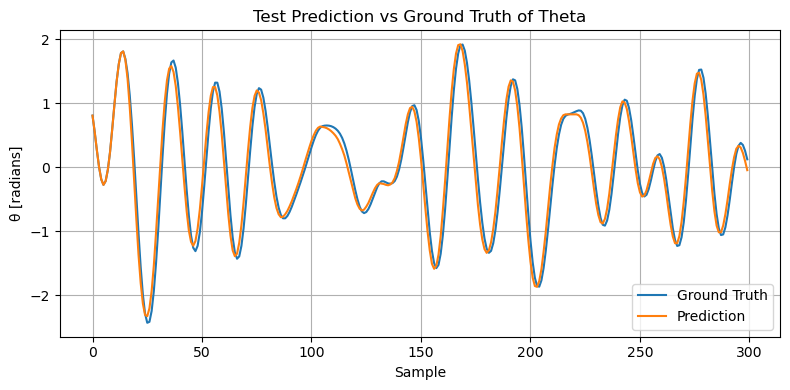

In [61]:
# --- Test Prediction vs Ground Truth ---
plt.figure(figsize=(8, 4))
plt.plot(th_sim[:300,0], label='Ground Truth')
plt.plot(Y_test_np[:300,0], label='Prediction')
plt.title('Test Prediction vs Ground Truth of Theta')
plt.xlabel('Sample')
plt.ylabel('θ [radians]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

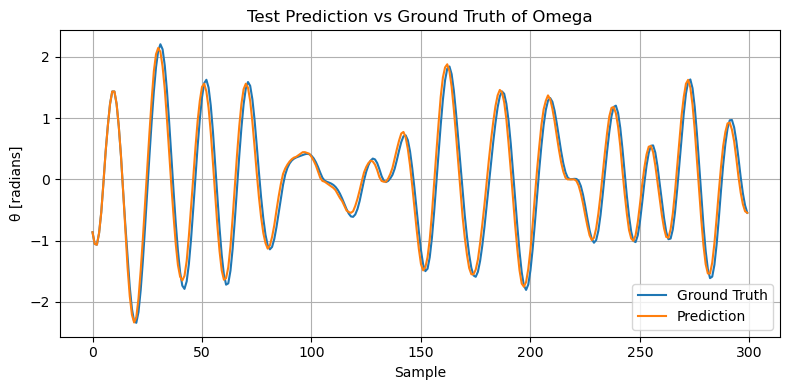

In [62]:
# --- Test Prediction vs Ground Truth ---
plt.figure(figsize=(8, 4))
plt.plot(th_sim[:300,1], label='Ground Truth')
plt.plot(Y_test_np[:300,1], label='Prediction')
plt.title('Test Prediction vs Ground Truth of Omega')
plt.xlabel('Sample')
plt.ylabel('θ [radians]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

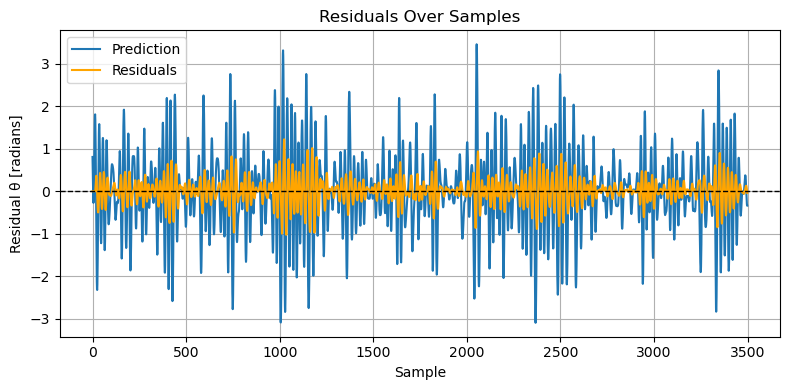

In [63]:
residuals = th_sim[:,0] - Y_test_np[:,0]



plt.figure(figsize=(8, 4))
plt.plot(Y_test_np[:,0], label='Prediction')
plt.plot(residuals, label='Residuals', color='orange')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Residuals Over Samples')
plt.xlabel('Sample')
plt.ylabel('Residual θ [radians]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

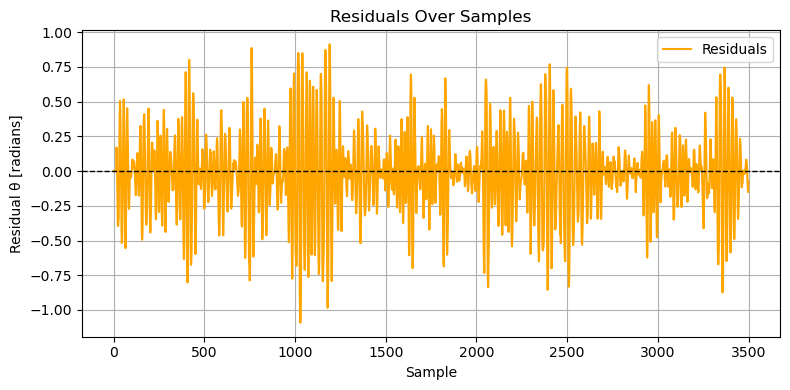

In [64]:
residuals = th_sim[:,1] - Y_test_np[:,1]

plt.figure(figsize=(8, 4))
plt.plot(residuals, label='Residuals', color='orange')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Residuals Over Samples')
plt.xlabel('Sample')
plt.ylabel('Residual θ [radians]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [68]:
import os

# Top 5 models and their sequence lengths (sl = sequence_length)
top_models = [
    {"path": "model_hs64_lr0.01_nl1_bs128_sl5_ep200_bi0_do0.2.pt", "hs": 64, "sl": 5},
    {"path": "model_hs64_lr0.01_nl1_bs64_sl10_ep200_bi0_do0.2.pt", "hs": 64, "sl": 10},
    {"path": "model_hs32_lr0.01_nl1_bs64_sl10_ep200_bi0_do0.pt", "hs": 32, "sl": 10},
    {"path": "model_hs32_lr0.01_nl1_bs64_sl5_ep200_bi0_do0.5.pt", "hs": 32, "sl": 5},
    {"path": "model_hs32_lr0.01_nl1_bs128_sl10_ep200_bi0_do0.5.pt", "hs": 32, "sl": 10},
]

base_path = r"C:\Users\xskap\Documents\Eindhoven\2025_Q4\5SC28_ML_systems_control\lstm\new_models"

for i, cfg in enumerate(top_models, 1):
    model_path = os.path.join(base_path, cfg["path"])
    hidden_size = cfg["hs"]
    sequence_length = cfg["sl"]
    skip = sequence_length

    # Load model
    model = NOELSTM(input_size=3,
                    hidden_size=hidden_size,
                    num_layers=1,
                    output_size=2,
                    bidirectional=False,
                    dropout=0.2).to(device)

    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()

    # Simulate
    th_sim = simulation_IO_model(
        lambda x: pytorch_predict(model, x),      
        X_test_np[:, -1, 2],
        Y_test_np[:, 0],
        Y_test_np[:, 1],
        na=sequence_length,
        nb=sequence_length,
        skip=skip
    )

    # Compute errors
    rms_rad = np.mean((th_sim[skip:, 0] - Y_test_np[skip:, 0])**2)**0.5
    rms_deg = rms_rad / (2 * np.pi) * 360
    nrms = rms_rad / X_test.std().item() * 100

    print(f"# {i}: {cfg['path']}")
    print(f"RMS: {rms_rad:.5f} rad | {rms_deg:.2f}° | NRMS: {nrms:.2f}%")
    print()


# 1: model_hs64_lr0.01_nl1_bs128_sl5_ep200_bi0_do0.2.pt
RMS: 0.30422 rad | 17.43° | NRMS: 30.69%

# 2: model_hs64_lr0.01_nl1_bs64_sl10_ep200_bi0_do0.2.pt
RMS: 0.25787 rad | 14.78° | NRMS: 26.02%

# 3: model_hs32_lr0.01_nl1_bs64_sl10_ep200_bi0_do0.pt
RMS: 0.22534 rad | 12.91° | NRMS: 22.73%

# 4: model_hs32_lr0.01_nl1_bs64_sl5_ep200_bi0_do0.5.pt
RMS: 0.25800 rad | 14.78° | NRMS: 26.03%

# 5: model_hs32_lr0.01_nl1_bs128_sl10_ep200_bi0_do0.5.pt
RMS: 0.35736 rad | 20.48° | NRMS: 36.05%

